In [1]:
import os
import pickle
#import sklearn
#from sklearn import metrics
#from sklearn import linear_model
from sklearn.model_selection import train_test_split
import random
import numpy as np
#from wac import WAC
from tqdm.notebook import tqdm
import pandas as pd
#from sklearn import neural_network
#import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict as dd
import nltk 
nltk.download('wordnet')
from operator import itemgetter
import warnings

[nltk_data] Downloading package wordnet to /home/crow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Hyperparameters

#concreteness_threshold = 2
concreteness_threshold = 8

# Number of positive examples we want for each classifier
#pos_count = 3
#neg_count = 9
#pos_count = 10
#neg_count = 20
pos_count = 15
neg_count = 40


test_pct = 0.33 #0.33

embedding_file = 'ddata/clip.bertvocab.embeddings.513.txt'
embedding_pickle = 'ddata/clip.bertvocab.embeddings.513.pkl'
concreteness_file = 'ddata/AC_ratings_google3m_koeper_SiW.csv'
concreteness_pickle = 'ddata/AC_ratings_google3m_koeper_SiW.pkl'

## Initiate Datasets

In [3]:
# wac2vec

if os.path.isfile(embedding_pickle):
    wac2vec = pickle.load(open(embedding_pickle, 'rb'))
else:
    with open(embedding_file) as f:
        f = f.readlines()
        f = [line.split() for line in f]
        wac2vec = {line[0]:np.array(line[1:], dtype=np.float32) for line in f}
        pickle.dump(wac2vec, open(embedding_pickle, "wb" ))

len(wac2vec)

30522

In [4]:
# concr_scores

if os.path.isfile(concreteness_pickle):
    concr_scores = pickle.load(open(concreteness_pickle, 'rb'))
else:
    concr_scores = pd.read_csv(concreteness_file, delimiter='\t')
    concr_scores = concr_scores.dropna()
    concr_scores.WORD = concr_scores.WORD.apply(lambda x: x.replace("_", " "))
    concr_scores.index = concr_scores.WORD
    pickle.dump(concr_scores, open(concreteness_pickle, "wb" ))

len(concr_scores)

2168990

## ConcreteAbstract Class

### Build Abstraction Tree

In [5]:
def init_abstraction_tree(min_rating=8):

    wac_words = list(wac2vec.keys())
    wn_words = set(i for i in wn.words())
    wn_wac_words = wn_words & set(wac_words)
    
    concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]
    leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]

    # Get Leaf Synsets...
    leaf_synsets = [wn.synsets(w)[0] for w in leaf_words]

    # Initiate Abstraction Tree
    embeddings = [wac2vec[w] for w in leaf_words]
    data = {
        "SYNSET" : leaf_synsets,
        "WORD" : leaf_words,
        "DIST2LEAF": [0]*len(leaf_synsets),
        "NUM_LEAVES": [1]*len(leaf_synsets),
        "HYPERNYM": [[]]*len(leaf_synsets),
        "HYPONYMS": [[]]*len(leaf_synsets),
        "EMBEDDING" : embeddings
        
    }
    abstraction_tree = pd.DataFrame(data)
    abstraction_tree.index = abstraction_tree.SYNSET

    # Get True Leaf Synsets
    ancestors = set()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for s in leaf_synsets:
            #print(set(s.closure(lambda s: s.hypernyms())))
            ancestors = ancestors.union(set(s.closure(lambda s: s.hypernyms())))

    # Remove leaves that are ancestors of other leaves
    true_leaf_synsets = set(leaf_synsets) - ancestors
    ansestor_leaves = set(leaf_synsets) - true_leaf_synsets
    abstraction_tree.drop(ansestor_leaves, inplace=True)
    
    # Remove leaves that have the same Synset
    abstraction_tree.drop_duplicates(subset='SYNSET', inplace=True)
    
    return abstraction_tree

In [6]:
# Grow abstraction tree

def update_dist2leaf(abstraction_tree, synset, dist):
    h_dist = abstraction_tree.loc[synset, 'DIST2LEAF']
    if h_dist > dist:
        return
    
    abstraction_tree.at[synset, 'DIST2LEAF'] = dist
    
    # go up the hypernym chain and set the distances
    h = abstraction_tree.loc[synset, 'HYPERNYM']
    if len(h) != 0:
        update_dist2leaf(abstraction_tree, h[0], dist+1)
        

def update_num_leaves(abstraction_tree, synset, num_leaves):
    orig_num_leaves = abstraction_tree.loc[synset, 'NUM_LEAVES']
    abstraction_tree.at[synset, 'NUM_LEAVES'] = orig_num_leaves + num_leaves
    
    # go up the hypernym chain and update the leaves
    h = abstraction_tree.loc[synset, 'HYPERNYM']
    if len(h) != 0:
        update_num_leaves(abstraction_tree, h[0], num_leaves)

def grow_abstraction_tree(abstraction_tree):
    """Takes an initial abstraction tree (containing only leaves) and grows
    the rest of the tree."""
    
    synset_list = list(abstraction_tree['SYNSET'])

    # Note: synset_list will grow as we loop through it, so tqdm may reach 100% before it's done
    for s in tqdm(synset_list):
        h = s.hypernyms()

        if len(h) == 0:
            continue

        h = h[0]

        if h not in abstraction_tree.SYNSET:
            synset_list.append(h)
            abstraction_tree.loc[h] = [
                h,    # SYNSET
                None, # WORD
                0,    # DIST2LEAF
                0,    # NUM_LEAVES
                [],   # HYPERNYM
                [],   # HYPONYMS
                None  # EMBEDDING
            ]

        # Set DIST2LEAF
        s_dist = abstraction_tree.loc[s, 'DIST2LEAF']
        update_dist2leaf(abstraction_tree, h, s_dist+1)
        #h_dist = abstraction_tree.loc[h, 'DIST2LEAF']
        #print(s)
        #if s_dist >= h_dist:
            #while abstraction_tree.loc[h, 'DIST2LEAF']
            #abstraction_tree.loc[h, 'DIST2LEAF'] = s_dist + 1

        # Set NUM_LEAVES
        s_num_leaves = abstraction_tree.loc[s, 'NUM_LEAVES']
        update_num_leaves(abstraction_tree, h, s_num_leaves)
        #h_num_leaves = abstraction_tree.loc[h, 'NUM_LEAVES']
        #abstraction_tree.loc[h, 'NUM_LEAVES'] = h_num_leaves + s_num_leaves

        # Add hypernym to synset
        abstraction_tree.loc[s, 'HYPERNYM'] = [h]

        # Add synset to hypernym
        abstraction_tree.loc[h, 'HYPONYMS'].append(s)

In [7]:
# Display abstraction tree
from nltk.tree import Tree

display_tree_call_limit = 0
   
def build_display_tree_safe(df, root_synset, char_limit=20):
    """Display an abstraction tree starting with the root_synset.
    Returns an nltk Tree structure.
    Do not use on big trees!"""
    
    global display_tree_call_limit
    display_tree_call_limit -= 1
    
    if display_tree_call_limit <= 0:
        warnings.warn("build_display_tree_safe reached maximum number of calls.")
        return "MAX"[:char_limit]
    
    row = df.loc[root_synset]
    root_name = row['SYNSET'].lemmas()[0].name()[:char_limit]
    if len(row['HYPONYMS']) == 0:
        return root_name
    
    children = [build_display_tree_safe(df, h, char_limit) for h in row['HYPONYMS']]
    
    return Tree(root_name, children)


def build_display_tree(df, root_synset, char_limit=20, call_limit=500):
    global display_tree_call_limit
    
    display_tree_call_limit = call_limit
    return build_display_tree_safe(df, root_synset, char_limit)
    

  0%|          | 0/14510 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

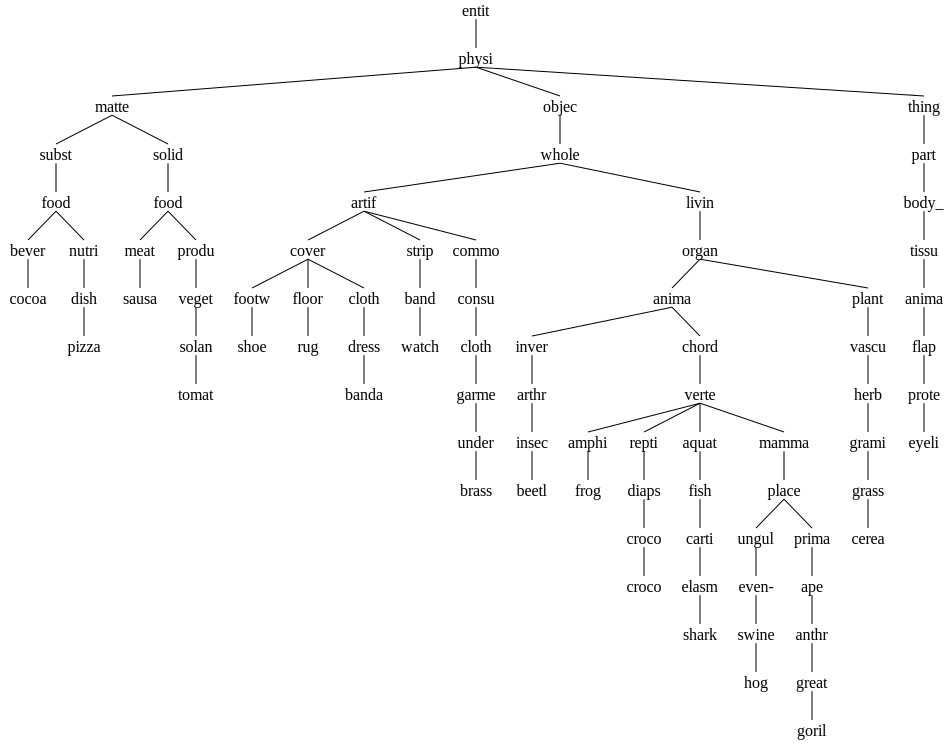

In [8]:
tmp_tree = init_abstraction_tree(9)
grow_abstraction_tree(tmp_tree)
build_display_tree(tmp_tree, wn.synset('entity.n.01'), char_limit=5)

In [9]:
abstraction_tree = init_abstraction_tree(concreteness_threshold)

  0%|          | 0/14510 [00:00<?, ?it/s]

In [10]:
grow_abstraction_tree(abstraction_tree)

  0%|          | 0/343 [00:00<?, ?it/s]

In [11]:
# Get Positive Synsets

In [12]:
def is_leaf(synset):
    if synset not in abstraction_tree.index:
        return False
    return abstraction_tree.loc[synset, 'DIST2LEAF'] == 0

def classifier_capable(synset):
    return abstraction_tree.loc[synset, 'NUM_LEAVES'] >= pos_count

def is_embedding_capable(synset):
    """Return true if the synset is capable of having an embedding."""
    if synset not in abstraction_tree.index:
        return False
    return is_leaf(synset) or classifier_capable(synset)

# dist2leaf gives us the furthest leaf.
# This can be used as a "sort" of way to determine abstraction level
def dist2leaf(synset):
    return abstraction_tree.loc[synset, 'DIST2LEAF']

def is_closer_to_leaf(synset, dist):
    """Return true if the synset is closer to a leaf than dist."""
    return dist2leaf(synset) < dist

def get_hyponyms(synset):
    """Return a list of hyponyms, or itself if there are none."""
    if synset not in abstraction_tree.index:
        return None
    hypos = abstraction_tree.loc[synset, 'HYPONYMS']
    if len(hypos) == 0:
        return [synset]
    else:
        return hypos

def count_embedding_capable(synset_list):
    """Given a list of synsets, returns a count of how many are capable of having an embedding."""
    return sum((is_embedding_capable(s) == True)*1 for s in synset_list)

def expand_hyponym_list(synset_list):
    hypos = []
    for s in synset_list:
        hypos += get_hyponyms(s)
    return hypos

def remove_embedding_incapable(synset_list):
    synset_list = np.array(synset_list)
    return list(synset_list[list(map(is_embedding_capable, synset_list))])

def find_positive_examples(synset, depth=100):
    pos = get_hyponyms(synset)
    for _ in range(depth):
        pos = expand_hyponym_list(pos)
        if count_embedding_capable(pos) >= pos_count:
            return remove_embedding_incapable(pos)
    
    raise Exception("Reached depth of {} without finding enough positive example: {}".format(depth, synset))

In [13]:
#find_positive_examples(wn.synset('artifact.n.01'))

In [14]:
# Find negative examples...

In [15]:
def find_negative_examples(synset, pos_examples):
    # All synsets
    neg = np.array(abstraction_tree['SYNSET'])
    # Embedding capable synsets
    neg = neg[list(map(is_embedding_capable, neg))]
    # Use only more concrete words (words that are closer to a leaf)
    dist2leaf = abstraction_tree.loc[synset, 'DIST2LEAF']
    neg = neg[list(map(lambda x: is_closer_to_leaf(x, dist2leaf), neg))]
    # neg examples not in positive examples
    neg = set(neg) - set(pos_examples)
    # Don't include yourself
    #neg.remove(synset) # removed by the closer check
    neg_examples = random.sample(list(neg), k=min(neg_count, len(neg)))
    return neg_examples

In [16]:
# add positive and negative examples for a single hypernym
def add_positive_negative_examples(synset):
    pos = find_positive_examples(synset)
    abstraction_tree.at[synset, 'POSITIVE'] = pos
    neg = find_negative_examples(synset, pos)
    abstraction_tree.at[synset, 'NEGATIVE'] = neg

In [17]:
def get_classifier_capable():
    """Get a list of synsets capable of having a classifier."""
    return [s for s in abstraction_tree['SYNSET'] if classifier_capable(s)]

In [18]:
# add positive and negative examples for all hypernyms
def add_pos_neg_all():
    """Add positive and negative examples for each calssifier capable synset."""
    abstraction_tree['POSITIVE'] = [[]]*len(abstraction_tree)
    abstraction_tree['NEGATIVE'] = [[]]*len(abstraction_tree)
    for s in tqdm(get_classifier_capable()):
        add_positive_negative_examples(s)

In [19]:
add_pos_neg_all()

  0%|          | 0/29 [00:00<?, ?it/s]

In [20]:
# Build Train/Test datasets

In [21]:
def build_train_test(synset):
    pos_examples = find_positive_examples(synset)
    neg_examples = find_negative_examples(synset, pos_examples)
    X = pos_examples + neg_examples
    y = list(np.ones(len(pos_examples))) + list(np.zeros(len(neg_examples)))
    return train_test_split(X, y, test_size=test_pct, stratify=y)

In [22]:
def fill_out_train_test():
    abstraction_tree['X_TRAIN'] = [[]]*len(abstraction_tree)
    abstraction_tree['X_TEST']  = [[]]*len(abstraction_tree)
    abstraction_tree['Y_TRAIN'] = [[]]*len(abstraction_tree)
    abstraction_tree['Y_TEST']  = [[]]*len(abstraction_tree)
    
    synsets = get_classifier_capable()
    for s in tqdm(synsets):
        X_train, X_test, y_train, y_test  = build_train_test(s)
        abstraction_tree.at[s, 'X_TRAIN'] = X_train
        abstraction_tree.at[s, 'X_TEST']  = X_test
        abstraction_tree.at[s, 'Y_TRAIN'] = y_train
        abstraction_tree.at[s, 'Y_TEST']  = y_test        

In [23]:
fill_out_train_test()

  0%|          | 0/29 [00:00<?, ?it/s]

In [24]:
# Train

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [26]:
def coefs(classifier):
    return classifier.coef_[0]

def build_classifiers():
    abstraction_tree['CLASSIFIER']  = [None]*len(abstraction_tree)
    cc = get_classifier_capable()
    # Start with synsets close to leaves and work our way up to more abstract hypernyms
    cc.sort(key=dist2leaf)
    for ss in tqdm(cc):
        #print(ss)
        X_train = abstraction_tree.loc[ss, 'X_TRAIN']
        y_train = abstraction_tree.loc[ss, 'Y_TRAIN']
        X_train = list(abstraction_tree.loc[X_train, 'EMBEDDING'])
        #lr = LogisticRegression()
        #lr = LogisticRegression(penalty='l2', solver='lbfgs', C=0.25)
        lr = LogisticRegression(C=0.25, max_iter=1000)
        lr.fit(X_train, y_train)
        abstraction_tree.at[ss, 'CLASSIFIER'] = lr
        abstraction_tree.at[ss, 'EMBEDDING'] = coefs(lr)
       
        

In [27]:
build_classifiers()

  0%|          | 0/29 [00:00<?, ?it/s]

In [28]:
#abstraction_tree.loc[get_classifier_capable(), 'EMBEDDING']

In [29]:
# Evaluate (vs negative examples)

In [30]:
# Random Baseline (vs negative examples)

In [31]:
def calc_random_baseline():
    pos, tot = 0, 0
    for ss in get_classifier_capable():
        y = abstraction_tree.loc[ss, 'Y_TRAIN']
        pos += sum(y)
        tot += len(y)
        y = abstraction_tree.loc[ss, 'Y_TEST']
        pos += sum(y)
        tot += len(y)
    return pos/tot

In [32]:
calc_random_baseline()

0.3302540415704388

In [33]:
# Most Common Baseline (vs negative examples)

In [34]:
1-calc_random_baseline()

0.6697459584295612

In [35]:
def evaluate_classifiers():
    golds = []
    preds = []
    cc = get_classifier_capable()
    # Evaluate in order (Not stricly needed, but helpful)
    cc.sort(key=dist2leaf)
    for ss in cc:
        X_test = abstraction_tree.loc[ss, 'X_TEST']
        y_test = abstraction_tree.loc[ss, 'Y_TEST']
        X_test = list(abstraction_tree.loc[X_test, 'EMBEDDING'])
        
        c = abstraction_tree.loc[ss, 'CLASSIFIER']
        pred = c.predict_proba(X_test)
        #pred = lr.predict_proba(X_test)
        pred = list(np.argmax(pred, axis=1))
        """
        print(ss)
        print(list(map(int, y_test)))
        print(pred)
        print(metrics.accuracy_score(y_test, pred))
        print()
        """
        preds = preds + pred
        golds = golds + y_test
    return metrics.accuracy_score(golds, preds)

In [36]:
evaluate_classifiers()

0.7372881355932204

In [37]:
# Evaluate (vs other classifiers)

In [38]:
def get_all_classifiers(abstraction_tree):
    classifiers = dd(None)
    for ss in get_classifier_capable():
        classf = abstraction_tree.loc[ss, 'CLASSIFIER']
        classifiers[ss] = classf

    return classifiers

In [39]:
def test_classifier_single(classifiers, x_ss, gold_ss, num_distractors=5):
    #gold_ss = wn.synset('conveyance.n.03')
    vec = abstraction_tree.loc[x_ss, 'EMBEDDING']
    probs = [(gold_ss, classifiers[gold_ss].predict_proba([vec])[0][1])]
    distractors=[]
    for _ in range(num_distractors):
        ss = random.choice(list(classifiers.keys()))
        if x_ss in abstraction_tree.loc[ss, 'POSITIVE']:
            continue
        if ss in distractors:
            continue
        distractors.append(ss)
        probs.append((ss, classifiers[ss].predict_proba([vec])[0][1]))
    best = max(probs, key=itemgetter(1))
    #print(x_ss, best[0], gold_ss)
    score = (best[0] == gold_ss)*1
    num_possibilities = len(probs) # To help calculate baseline
    return score, num_possibilities

In [40]:
def test_classifier_full(classifiers, gold_ss, num_distractors=5):
    test = abstraction_tree.loc[gold_ss, 'X_TEST']
    pos = abstraction_tree.loc[gold_ss, 'POSITIVE']
    X = set(test).intersection(pos)
    total_score = 0
    total_possibilities = 0
    total_tests = len(X)
    for x in X:
        score, num_possibilities = test_classifier_single(classifiers, x, gold_ss, num_distractors)
        total_score += score
        total_possibilities += num_possibilities
    return total_score, total_tests, total_possibilities

In [41]:
#gold_ss = wn.synset('mammal.n.01')
#test_classifier_full(gold_ss, num_distractors=10)

In [42]:
# test/evaluate all classifiers
def evaluate_all_classifiers(classifiers, num_distractors=10):
    grand_total_score, grand_total_tests, grand_total_possibilities = 0,0,0
    for gold_ss in tqdm(classifiers.keys()):
        #print(gold_ss)
        total_score, total_tests, total_possibilities = test_classifier_full(classifiers, gold_ss, num_distractors)
        #print(total_score, total_tests, total_possibilities)
        grand_total_score += total_score
        grand_total_tests += total_tests
        grand_total_possibilities += total_possibilities

    score = grand_total_score/grand_total_tests
    baseline = grand_total_tests/grand_total_possibilities

    return score, baseline

In [43]:
classifiers = get_all_classifiers(abstraction_tree)

In [44]:
score, baseline = evaluate_all_classifiers(classifiers, 10)
print("score:    ", score)
print("baseline: ", baseline)

  0%|          | 0/29 [00:00<?, ?it/s]

score:     0.47643979057591623
baseline:  0.11208920187793427


In [45]:
# Total Classifiers
len(get_classifier_capable())

29

In [46]:
# Total Lemmas
sum(len(ss.lemmas()) for ss in get_classifier_capable())

55

In [47]:
wn.synset('entity.n.01')

Synset('entity.n.01')

In [48]:
abstraction_tree.loc[wn.synset('entity.n.01'), 'HYPONYMS']

[Synset('physical_entity.n.01'), Synset('abstraction.n.06')]

In [49]:
abstraction_tree.loc[wn.synset('abstraction.n.06'), 'HYPONYMS']

[Synset('group.n.01'),
 Synset('communication.n.02'),
 Synset('attribute.n.02'),
 Synset('relation.n.01'),
 Synset('psychological_feature.n.01'),
 Synset('measure.n.02')]

In [50]:
abstraction_tree.loc[wn.synset('physical_entity.n.01'), 'HYPONYMS']

[Synset('object.n.01'),
 Synset('matter.n.03'),
 Synset('causal_agent.n.01'),
 Synset('thing.n.12'),
 Synset('process.n.06')]

In [51]:
def visual_get_categories(start_ss, depth=1):
    hypos = abstraction_tree.loc[start_ss, 'HYPONYMS']
    if depth <= 0:
        return hypos
    
    ret = []
    for h in hypos:
        ret = ret + get_categories(h, depth-1)
    return ret
    

In [52]:
def get_offspring(parent_ss):
    offspring = []
    absraction_levels = []
    hypos = abstraction_tree.loc[parent_ss, 'HYPONYMS']
    emb = abstraction_tree.loc[parent_ss, 'EMBEDDING']
    a_level = abstraction_tree.loc[parent_ss, 'DIST2LEAF']

    #print(parent_ss)
    #print(emb)
    #print(hypos)
    if emb is not None:
        offspring.append(emb)
        absraction_levels.append(a_level)
    for ss in hypos:
        off, a_level = get_offspring(ss)
        offspring += off
        absraction_levels += a_level
    return offspring, absraction_levels

In [53]:
def visual_get_X_features(ss_list):
    X_features = []
    X_colors = []
    for i, parent_ss in enumerate(ss_list):
        offspring, a_levels = get_offspring(parent_ss)
        X_features += offspring
        #X_colors += [i]*len(offspring)
        X_colors += a_levels
    
    return X_features, X_colors    

In [54]:
visual_categories = visual_get_categories(wn.synset('entity.n.01'), 0)

In [55]:
X_features, X_colors = visual_get_X_features(visual_categories)

In [56]:
#get_offspring(wn.synset('lepidopterous_insect.n.01'))

In [57]:
#X_colors[-1]

In [58]:
len(X_colors)

360

In [59]:
len(X_features)

360

In [60]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [61]:
# Visualize
pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

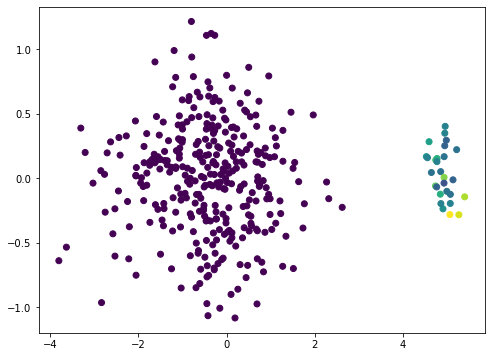

In [62]:
pca2 = PCA(n_components=17)
pca2.fit(X_features)
x_3d = pca2.transform(X_features)

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,5], c=X_colors)
plt.show()